In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    !pip install livelossplot
print(torchbearer.__version__)

     |████████████████████████████████| 138 kB 32.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0.5.3


In [3]:
import os
os.listdir('/content/drive/MyDrive/ANN-HW4/Linnaeus5/train')

['berry', 'bird', 'dog', 'flower', 'other']

In [4]:
pic_selected = sorted(os.listdir("/content/drive/MyDrive/ANN-HW4/Linnaeus5/train"))
pic_selected

['berry', 'bird', 'dog', 'flower', 'other']

In [5]:
data_dir="/content/drive/MyDrive/ANN-HW4/Linnaeus5/train"

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

rows = 1
cols = 5
counter=0
data=[]
label=[]
for pic_id in pic_selected:
  counter=pic_selected.index(pic_id)
  pic_selected_images = os.listdir(os.path.join(data_dir,pic_id))
  for id in pic_selected_images:
    data.append(plt.imread(os.path.join(data_dir,pic_id, id)))
    label.append(counter)

    

In [7]:
dataset=np.array(data)
labels=np.array(label)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(dataset, labels, test_size=0.2, random_state=1)

In [9]:
X_train=X_train/256
X_eval=X_eval/256

In [10]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=5)
y_eval = to_categorical(y_eval, num_classes=5)

In [11]:
import keras
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [12]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, Input, BatchNormalization, Add, LeakyReLU, GlobalMaxPooling2D,concatenate
from keras.regularizers import l1_l2

inp=Input(shape=(128,128,3), name="Input")
y=inp
x = inception_module(inp,
                     filters_1x1=32,
                     filters_3x3_reduce=16,
                     filters_3x3=32,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_1')
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2, 2))(x)
x = LeakyReLU(alpha=0.02)(x)
x=Dropout(0.2)(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=16,
                     filters_3x3=32,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_2')
x=BatchNormalization()(x)
x=MaxPool2D(pool_size=(2, 2))(x)
x = LeakyReLU(alpha=0.02)(x)
x=Dropout(0.2)(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=16,
                     filters_3x3=32,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3')
x=BatchNormalization()(x)

skip=Conv2D(128,kernel_size=3,strides=1, padding='same')(inp)
skip=MaxPool2D(pool_size=(4, 4))(skip)
x=Add()([x,skip])
x = LeakyReLU(alpha=0.02)(x)

x=GlobalMaxPooling2D()(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.2)(x)
Output=Dense(5,activation="softmax")(x)

model = Model(inputs=inp, outputs=Output, name='ResNet')

In [17]:
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  64          ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 16  64          ['Input[0][0]']                  
                                )                                                            

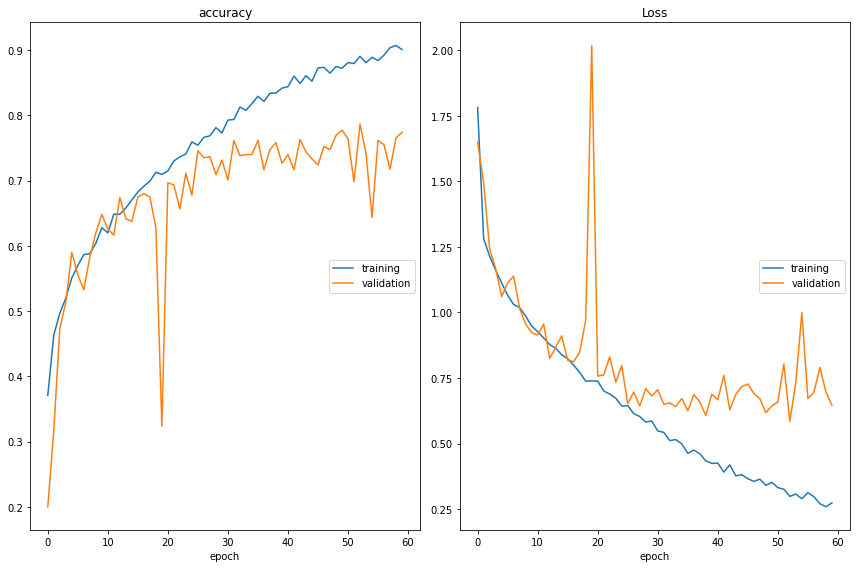

accuracy
	training         	 (min:    0.371, max:    0.907, cur:    0.901)
	validation       	 (min:    0.200, max:    0.787, cur:    0.774)
Loss
	training         	 (min:    0.259, max:    1.781, cur:    0.274)
	validation       	 (min:    0.585, max:    2.018, cur:    0.646)


In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from livelossplot import PlotLossesKeras

n_epochs = 60

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(X_train, y_train,batch_size=20,shuffle=True,
                    epochs=n_epochs, 
                    validation_data=(X_eval,y_eval),
                    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
                    verbose=False)

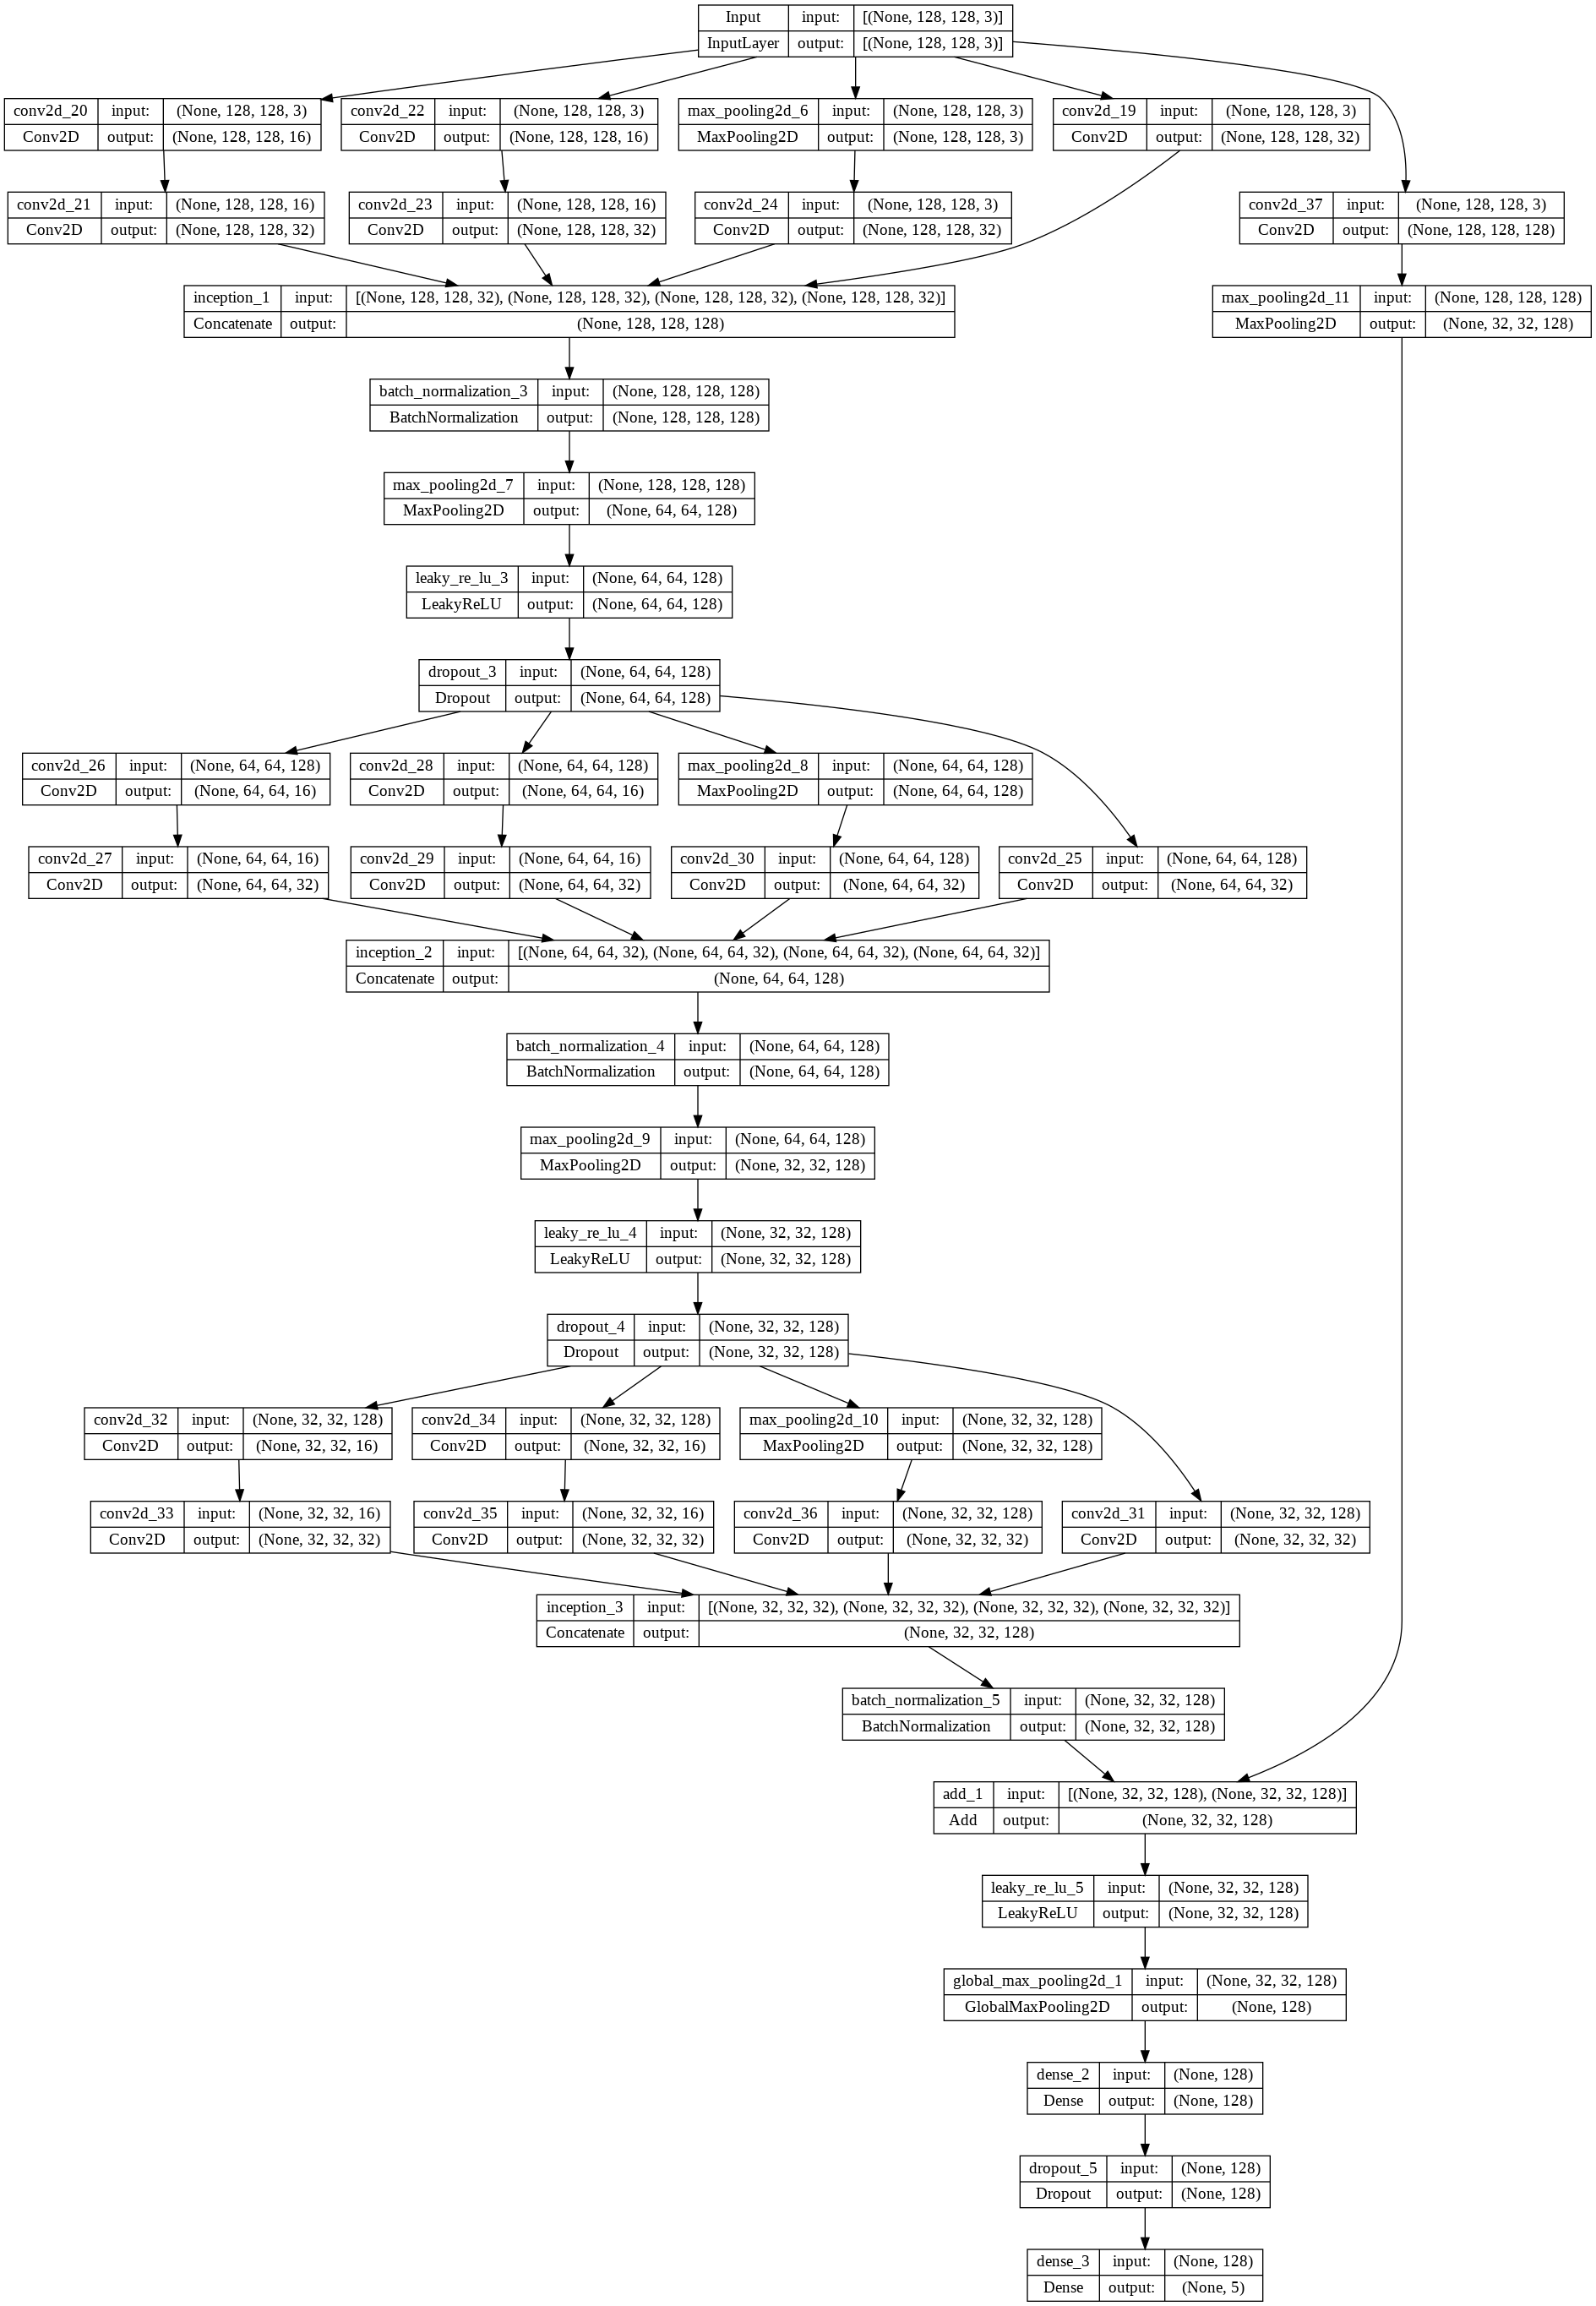

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
model.save('Inception1.h5')